In [1]:
import json
import pandas as pd
from yome import Session
from yome.models import *
from yome.util import to_df
import re
from sqlalchemy.orm import aliased
import itertools as it
import seaborn as sns
from IPython.display import HTML

In [2]:
pd.set_option('display.max_colwidth', -1)

In [3]:
from mpl_recipes import mpl_setup
%mpl_setup

Populating the interactive namespace from numpy and matplotlib


In [4]:
session = Session()

# Psuedogenes 

In [5]:
# Genes maked pseudo in EcoGene
ecogene_pseudo = (
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseFeature.feature)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .join(KnowledgebaseFeature)
    .filter(Knowledgebase.name == 'EcoGene')
    .filter(KnowledgebaseFeature.feature_type == 'is_pseudogene')
    .filter(KnowledgebaseFeature.feature == 't')
)

In [6]:
ecogene_pseudo.count()

184

# Genes without b-number

In [7]:
# Genes b4309 pseudo in EcoGene
no_b_number = to_df(
    session.query(KnowledgebaseGene.primary_name,
                  KnowledgebaseGene.annotation_quality,
                  Knowledgebase.name.label('kb_name'))
    .join(Knowledgebase)
    .filter(KnowledgebaseGene.gene_id == None)
)

In [8]:
no_b_number.groupby('kb_name').agg('count')

,primary_name,annotation_quality
kb_name,,
EcoCyc,55,55
UniProt,1,1


# Find locus tags with multiple genes

In [9]:
KnowledgebaseGene2 = aliased(KnowledgebaseGene)

In [10]:
duplicates = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseGene2.primary_name.label('primary_name2'),
                  Knowledgebase.name)
    .join(KnowledgebaseGene, KnowledgebaseGene.gene_id == Gene.id)
    .join(KnowledgebaseGene2, KnowledgebaseGene2.gene_id == Gene.id)
    .join(Knowledgebase, KnowledgebaseGene.knowledgebase_id == Knowledgebase.id)
    .filter(KnowledgebaseGene2.knowledgebase_id == Knowledgebase.id)
    .filter(KnowledgebaseGene.id != KnowledgebaseGene2.id)
)

In [11]:
duplicates

,locus_id,primary_name,primary_name2,name
0,b3504,yhiS_2,yhiS_1,EcoCyc
1,b0240,crl_1,crl_2,EcoCyc
2,b0240,crl_2,crl_1,EcoCyc
3,b3504,yhiS_1,yhiS_2,EcoCyc
4,b4581,ybeM,ybeH,UniProt
5,b4581,ybeH,ybeM,UniProt


# Kbase comparison plot
NOTE: 55 EcoCyc & 1 UniProt genes without a locus tag and 4 EcoCyc genes with duplicated locus tags are ignored in this plot

In [35]:
kbases = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseGene.annotation_quality,
                  Knowledgebase.name.label('knowledgebase_name'))
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
)

In [36]:
def calculate_y_ome(row):
    return 'high' if any(x == 'high' for x in row) \
      else 'low'  if any(x == 'low' for x in row) \
      else 'tbd'

In [37]:
# remove duplicate genes
kbases_unstacked = kbases.set_index(['locus_id', 'knowledgebase_name'])
kbases_unstacked = kbases_unstacked[~kbases_unstacked.index.duplicated(keep='first')]
kbases_unstacked = kbases_unstacked.drop('primary_name', axis=1).unstack()
kbases_unstacked.columns = kbases_unstacked.columns.droplevel(0)
# calculate Y-ome; don't rely on ME-model
kbases_unstacked['Y-ome'] = kbases_unstacked[kbases_unstacked.columns.drop('iJL1678b')].apply(calculate_y_ome, axis=1)

In [38]:
# Y-ome counts
kbases_unstacked['Y-ome'].value_counts()

high    2189
low     1808
tbd     656 
Name: Y-ome, dtype: int64

In [39]:
levels = {
    'excluded': 0,
    'tbd': 1,
    'low': 2,
    'high': 3,
    None: 4
}

In [40]:
colors = {
    0: [ 0.85453713,  0.22957019,  0.27623218,  1.        ], # bright red
    1: [ 0.9170408 ,  0.56061475,  0.58722664,  1.        ], # red
    2: [ 0.57653009,  0.72175186,  0.76633449,  1.        ], # light blue green
    3: [ 0.24715576,  0.49918708,  0.57655991,  1.        ], # dark blue green
    4: [ 0.6,         0.6,         0.6,         1.        ], # grey
}

In [41]:
knowledgebase_names = list(kbases_unstacked.columns)
kbases_plot = kbases_unstacked.applymap(lambda x: levels[x]).sort_values(by=list(kbases_unstacked.columns))
kbases_plot.head()

knowledgebase_name,EcoCyc,EcoGene,RefSeq,UniProt,iJL1678b,Y-ome
locus_id,,,,,,
b0240,0,0,1,1,4,1
b0229,0,0,1,2,4,2
b0230,0,0,1,2,4,2
b0235,0,0,1,2,4,2
b0236,0,0,1,2,4,2


In [42]:
# create bars based on consecutive colors
last_value = {kbase: None for kbase in knowledgebase_names}
bars = {kbase: [] for kbase in knowledgebase_names}
for locus_tag, row in kbases_plot.iterrows():
    for kbase, value in row.iteritems():
        if len(bars[kbase]) == 0 or bars[kbase][-1]['value'] != value:
            bars[kbase].append({'value': value, 'height': 1})
            last_value[kbase] = value
        else:
            bars[kbase][-1]['height'] += 1

[array([ 0.85453713,  0.22957019,  0.27623218,  1.        ]),
 array([ 0.9170408 ,  0.56061475,  0.58722664,  1.        ]),
 array([ 0.98157711,  0.90242499,  0.90833474,  1.        ]),
 array([ 0.95,  0.95,  0.95,  1.  ]),
 array([ 0.91661578,  0.95155452,  0.9622806 ,  1.        ]),
 array([ 0.57653009,  0.72175186,  0.76633449,  1.        ]),
 array([ 0.24715576,  0.49918708,  0.57655991,  1.        ])]

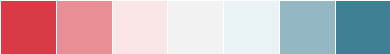

In [43]:
pal = sns.diverging_palette(10, 220, sep=80, n=7)
sns.palplot(pal)
pal

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


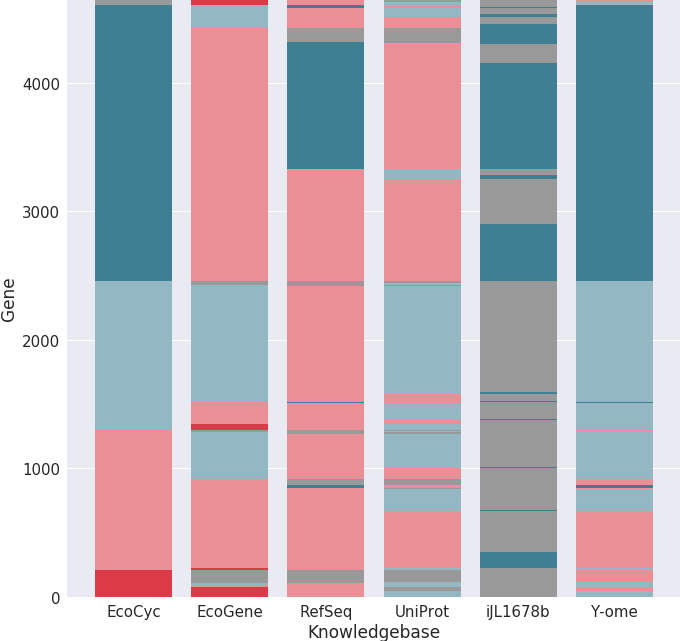

In [44]:
fig, ax = plt.subplots(figsize=(11, 11))
last_heights = [0 for _ in knowledgebase_names]
for bar_list in it.zip_longest(*bars.values()):
    left = [x + 0.1 for x in range(len(knowledgebase_names))]
    height = [x['height'] if x is not None else 0 for x in bar_list]
    bottom = last_heights
    last_heights = [x + y for x, y in zip(height, last_heights)]
    color = [colors[x['value']] if x is not None else 'k' for x in bar_list]
    ax.bar(left, height, bottom=bottom, color=color, linewidth=0)
ax.set_xlabel('Knowledgebase')
ax.set_ylabel('Gene')
ax.xaxis.set_ticks([x + 0.1 for x in range(len(kbases_plot.columns))])
ax.xaxis.set_ticklabels(kbases_plot.columns)

## cases to check:

### High in one DB, low in another

+ High in EcoCyc and low in EcoGene
  + result: based on *caiC*, give "high" priority over "low" because EcoCyc has more up-to-date information for "high" cases
+ High in UniProt and low in EcoCyc
  + result: based on *yadI / b0129*, don't rely on EC number in UniProt; use annotation score instead
  + result: based on *mrdB*, don't categorize "family protein" as poor annotation in EcoCyc
  + result: based on *YdcE / b1461*, UniProt high should override EcoCyc because EcoCyc missed the experimental validation in the linked paper
    + good example for the text
  + result: based on *dgcJ / b1786*, uniprot level 5 annotation should be "low", because even putative functions are given this level of annotation
    + also a good example for the text
+ High in ME-model, low in EcoCyc
  + result: ME-model includes putative annotations (e.g. YaaJ). Don't mark these as high
  + TODO provide an analysis of them in the text

## Assertions
The literature points to a particular answer for these genes

In [94]:
assertions = [
    ('b1461', 'high'),
    ('b0129', 'low'),
    ('b1786', 'low'),
]
# print an incorrect assertions
def check_for_row(row):
    return any(row.name == locus_tag and row['Y-ome'] != val 
               for locus_tag, val in assertions)
kbases_unstacked[kbases_unstacked.apply(check_for_row, axis=1)]

knowledgebase_name,EcoCyc,EcoGene,RefSeq,UniProt,iJL1678b,Y-ome
locus_id,,,,,,


## Get a case

In [57]:
kbases_unstacked.loc['b1461']

knowledgebase_name
EcoCyc      low 
EcoGene     tbd 
RefSeq      high
UniProt     tbd 
iJL1678b    None
Y-ome       high
Name: b1461, dtype: object

In [58]:
kbases_in_yome = kbases_unstacked.drop('iJL1678b', axis=1)
kbases_in_yome[(kbases_in_yome == 'low').any(axis=1) & (kbases_in_yome == 'high').any(axis=1)]

knowledgebase_name,EcoCyc,EcoGene,RefSeq,UniProt,Y-ome
locus_id,,,,,
b0034,high,tbd,tbd,low,high
b0037,high,low,high,low,high
b0040,high,low,tbd,tbd,high
b0084,high,low,tbd,tbd,high
b0089,high,low,tbd,low,high
b0211,high,low,high,tbd,high
b0219,high,low,tbd,low,high
b0260,high,low,tbd,low,high
b0261,high,low,high,tbd,high


# All information for a gene

In [73]:
# Get TBD genes for EcoGene but high for Eco
report = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseGene.annotation_quality,
                  Knowledgebase.name.label('knowledgebase_name'),
                  KnowledgebaseFeature.feature_type,
                  KnowledgebaseFeature.feature)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .join(KnowledgebaseFeature)
    .filter(Gene.locus_id == 'b0034')
)

In [74]:
report.iloc[0, 0:2]

locus_id        b0037
primary_name    caiC 
Name: 0, dtype: object

In [75]:
report.knowledgebase_name = report.apply(lambda row: f"{row['knowledgebase_name']} ({row['annotation_quality']})", axis=1)
report = report.drop(['locus_id', 'primary_name', 'annotation_quality'], axis=1)
report = report.set_index(['knowledgebase_name', 'feature_type'])
s = report.style.set_properties(**{'text-align': 'left'})
HTML(s.render())